Comparison of Optimization Algorithms for Total Variation Denoising
===================================================================

This example compares the performance of ADMM, Linearized ADMM, and PDHG
in solving the isotropic total variation (TV) denoising problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - \mathbf{x}
  \|^2 + \lambda R(\mathbf{x}) \;,$$

where $R$ is the isotropic TV: the sum of the norms of the gradient
vectors at each point in the image $\mathbf{x}$.

In [1]:
import jax

from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, plot
from scico.admm import ADMM, LinearSubproblemSolver
from scico.ladmm import LinearizedADMM
from scico.primaldual import PDHG
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
phantom = SiemensStar(32)
x_gt = snp.pad(discrete_phantom(phantom, 240), 8)
x_gt = jax.device_put(x_gt)  # convert to jax type, push to GPU

2021-11-30 09:41:05.294981: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2021-11-30 09:41:05.295424: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.74.0 does not match DSO version 470.86.0 -- cannot find working devices in this configuration


Add noise to create a noisy test image.

In [3]:
σ = 1.0  # noise standard deviation
noise, key = scico.random.randn(x_gt.shape, seed=0)
y = x_gt + σ * noise

Construct operators and functionals and set regularization parameter.

In [4]:
# The append=0 option makes the results of horizontal and vertical
# finite differences the same shape, which is required for the L21Norm.
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
f = loss.SquaredL2Loss(y=y)
λ = 1e0
g = λ * functional.L21Norm()

For reasons that are not entirely clear, the first step of the first-run
solver is much slower than the following steps. Perform a preliminary
solver step, the result of which is discarded, to avoid this bias in the
timing results.

In [5]:
solver_admm = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=1,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": 1}),
    verbose=False,
)
solver_admm.solve()
# trailing semi-colon suppresses output in notebook

DeviceArray([[-0.24786384, -1.1357065 ,  0.7003422 , ..., -0.8544905 ,
               0.6193555 , -0.96835625],
             [-0.62094545,  0.7834149 ,  1.4034015 , ..., -1.3127651 ,
               1.0881041 , -0.5299222 ],
             [ 1.1058918 ,  0.7715796 ,  1.6384543 , ...,  0.10172751,
              -0.99110496, -1.2500168 ],
             ...,
             [-1.1386425 ,  0.04489056, -0.3303884 , ..., -0.3450504 ,
               1.7291036 ,  0.81530505],
             [ 0.23897338, -1.2539681 ,  0.9339851 , ..., -0.19375211,
               1.4446731 ,  1.5074188 ],
             [ 0.2805901 , -0.58232826,  0.5705929 , ...,  0.01591457,
              -1.238526  ,  0.9255734 ]], dtype=float32)

Solve via ADMM with a maximum of 2 CG iterations.

In [6]:
solver_admm = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=200,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": 2}),
    verbose=True,
)
print(f"Solving on {device_info()}\n")
solver_admm.solve()
hist_admm = solver_admm.itstat_object.history(transpose=True)

Solving on CPU

Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  1.64e-01  1.087e+05    2.558e+01  5.289e+01
   1  1.92e-01  1.044e+05    1.379e+00  5.160e+01


   2  2.02e-01  9.945e+04    1.193e+00  4.942e+01
   3  2.11e-01  9.477e+04    1.297e+00  4.808e+01
   4  2.19e-01  9.036e+04    1.434e+00  4.676e+01
   5  2.27e-01  8.621e+04    1.524e+00  4.544e+01
   6  2.36e-01  8.229e+04    1.619e+00  4.411e+01
   7  2.44e-01  7.862e+04    1.702e+00  4.277e+01
   8  2.52e-01  7.517e+04    1.784e+00  4.142e+01
   9  2.60e-01  7.194e+04    1.821e+00  4.009e+01
  10  2.69e-01  6.892e+04    1.857e+00  3.876e+01
  11  2.77e-01  6.610e+04    1.891e+00  3.744e+01
  12  2.85e-01  6.347e+04    1.937e+00  3.612e+01
  13  2.94e-01  6.103e+04    1.965e+00  3.480e+01
  14  3.02e-01  5.877e+04    1.948e+00  3.350e+01
  15  3.10e-01  5.666e+04    1.944e+00  3.222e+01
  16  3.18e-01  5.472e+04    1.957e+00  3.096e+01
  17  3.26e-01  5.293e+04    1.978e+00  2.971e+01
  18  3.33e-01  5.127e+04    1.954e+00  2.850e+01
  19  3.41e-01  4.975e+04    1.915e+00  2.731e+01
  20  3.49e-01  4.835e+04    1.899e+00  2.614e+01
  21  3.57e-01  4.708e+04    1.895e+00  2.499e+01


  28  4.11e-01  4.078e+04    1.646e+00  1.783e+01
  29  4.18e-01  4.018e+04    1.609e+00  1.693e+01
  30  4.26e-01  3.964e+04    1.546e+00  1.607e+01
  31  4.34e-01  3.916e+04    1.499e+00  1.523e+01
  32  4.42e-01  3.872e+04    1.467e+00  1.443e+01
  33  4.49e-01  3.833e+04    1.418e+00  1.366e+01
  34  4.57e-01  3.798e+04    1.376e+00  1.292e+01
  35  4.64e-01  3.767e+04    1.343e+00  1.220e+01
  36  4.71e-01  3.739e+04    1.299e+00  1.150e+01
  37  4.79e-01  3.715e+04    1.258e+00  1.083e+01
  38  4.87e-01  3.693e+04    1.229e+00  1.020e+01
  39  4.95e-01  3.673e+04    1.181e+00  9.594e+00
  40  5.03e-01  3.656e+04    1.140e+00  9.024e+00
  41  5.15e-01  3.641e+04    1.092e+00  8.481e+00
  42  5.23e-01  3.628e+04    1.063e+00  7.956e+00
  43  5.31e-01  3.616e+04    1.027e+00  7.458e+00
  44  5.39e-01  3.606e+04    1.007e+00  6.975e+00
  45  5.47e-01  3.596e+04    9.909e-01  6.510e+00
  46  5.54e-01  3.588e+04    9.675e-01  6.077e+00
  47  5.61e-01  3.581e+04    9.604e-01  5.658e+00


  54  6.13e-01  3.551e+04    7.821e-01  3.515e+00
  55  6.21e-01  3.548e+04    7.561e-01  3.293e+00
  56  6.28e-01  3.546e+04    7.188e-01  3.096e+00
  57  6.35e-01  3.544e+04    6.825e-01  2.925e+00
  58  6.43e-01  3.542e+04    6.478e-01  2.766e+00
  59  6.50e-01  3.540e+04    6.146e-01  2.618e+00
  60  6.57e-01  3.539e+04    5.862e-01  2.480e+00
  61  6.65e-01  3.537e+04    5.605e-01  2.341e+00
  62  6.77e-01  3.536e+04    5.358e-01  2.211e+00
  63  6.86e-01  3.535e+04    5.110e-01  2.088e+00
  64  6.95e-01  3.534e+04    4.880e-01  1.973e+00
  65  7.04e-01  3.533e+04    4.643e-01  1.864e+00
  66  7.13e-01  3.533e+04    4.458e-01  1.757e+00
  67  7.22e-01  3.532e+04    4.259e-01  1.657e+00
  68  7.31e-01  3.531e+04    4.056e-01  1.566e+00
  69  7.40e-01  3.531e+04    3.856e-01  1.483e+00
  70  7.50e-01  3.530e+04    3.650e-01  1.409e+00
  71  7.60e-01  3.530e+04    3.451e-01  1.343e+00
  72  7.69e-01  3.529e+04    3.270e-01  1.280e+00
  73  7.78e-01  3.529e+04    3.119e-01  1.215e+00


  77  8.15e-01  3.528e+04    2.550e-01  9.939e-01
  78  8.25e-01  3.528e+04    2.450e-01  9.443e-01
  79  8.34e-01  3.527e+04    2.321e-01  8.975e-01
  80  8.43e-01  3.527e+04    2.217e-01  8.554e-01
  81  8.56e-01  3.527e+04    2.111e-01  8.157e-01
  82  8.65e-01  3.527e+04    2.013e-01  7.777e-01
  83  8.74e-01  3.527e+04    1.926e-01  7.382e-01
  84  8.83e-01  3.527e+04    1.819e-01  7.043e-01
  85  8.92e-01  3.527e+04    1.744e-01  6.716e-01
  86  9.02e-01  3.526e+04    1.649e-01  6.424e-01
  87  9.11e-01  3.526e+04    1.569e-01  6.161e-01
  88  9.20e-01  3.526e+04    1.506e-01  5.868e-01
  89  9.29e-01  3.526e+04    1.437e-01  5.592e-01
  90  9.39e-01  3.526e+04    1.380e-01  5.328e-01
  91  9.48e-01  3.526e+04    1.303e-01  5.095e-01
  92  9.57e-01  3.526e+04    1.238e-01  4.881e-01
  93  9.66e-01  3.526e+04    1.182e-01  4.657e-01
  94  9.75e-01  3.526e+04    1.135e-01  4.446e-01
  95  9.84e-01  3.526e+04    1.077e-01  4.259e-01
  96  9.93e-01  3.526e+04    1.027e-01  4.085e-01


  99  1.02e+00  3.526e+04    8.869e-02  3.604e-01
 100  1.03e+00  3.526e+04    8.452e-02  3.462e-01
 101  1.04e+00  3.526e+04    8.093e-02  3.321e-01
 102  1.05e+00  3.526e+04    7.665e-02  3.193e-01
 103  1.06e+00  3.526e+04    7.281e-02  3.073e-01
 104  1.06e+00  3.526e+04    6.961e-02  2.948e-01
 105  1.07e+00  3.526e+04    6.630e-02  2.831e-01
 106  1.08e+00  3.526e+04    6.338e-02  2.718e-01
 107  1.09e+00  3.526e+04    6.020e-02  2.615e-01
 108  1.09e+00  3.526e+04    5.749e-02  2.519e-01
 109  1.10e+00  3.526e+04    5.505e-02  2.423e-01
 110  1.11e+00  3.526e+04    5.323e-02  2.325e-01
 111  1.12e+00  3.526e+04    5.080e-02  2.227e-01
 112  1.14e+00  3.526e+04    4.783e-02  2.148e-01
 113  1.15e+00  3.526e+04    4.570e-02  2.074e-01
 114  1.16e+00  3.525e+04    4.375e-02  2.000e-01
 115  1.17e+00  3.525e+04    4.191e-02  1.930e-01
 116  1.18e+00  3.525e+04    4.050e-02  1.856e-01
 117  1.19e+00  3.525e+04    3.885e-02  1.788e-01
 118  1.19e+00  3.525e+04    3.820e-02  1.711e-01


 122  1.23e+00  3.525e+04    3.270e-02  1.442e-01
 123  1.24e+00  3.525e+04    3.162e-02  1.386e-01
 124  1.25e+00  3.525e+04    3.024e-02  1.338e-01
 125  1.26e+00  3.525e+04    2.905e-02  1.294e-01
 126  1.27e+00  3.525e+04    2.799e-02  1.248e-01
 127  1.28e+00  3.525e+04    2.726e-02  1.203e-01
 128  1.29e+00  3.525e+04    2.600e-02  1.163e-01
 129  1.30e+00  3.525e+04    2.503e-02  1.126e-01
 130  1.31e+00  3.525e+04    2.413e-02  1.088e-01
 131  1.32e+00  3.525e+04    2.328e-02  1.053e-01
 132  1.32e+00  3.525e+04    2.245e-02  1.019e-01
 133  1.33e+00  3.525e+04    2.165e-02  9.856e-02
 134  1.34e+00  3.525e+04    2.092e-02  9.536e-02
 135  1.35e+00  3.525e+04    2.023e-02  9.228e-02
 136  1.36e+00  3.525e+04    1.959e-02  8.931e-02
 137  1.37e+00  3.525e+04    1.913e-02  8.589e-02
 138  1.38e+00  3.525e+04    1.857e-02  8.297e-02
 139  1.38e+00  3.525e+04    1.793e-02  8.030e-02
 140  1.39e+00  3.525e+04    1.743e-02  7.768e-02
 141  1.40e+00  3.525e+04    1.697e-02  7.518e-02


 146  1.44e+00  3.525e+04    1.528e-02  6.345e-02
 147  1.45e+00  3.525e+04    1.464e-02  6.131e-02
 148  1.46e+00  3.525e+04    1.430e-02  5.949e-02
 149  1.46e+00  3.525e+04    1.396e-02  5.766e-02
 150  1.47e+00  3.525e+04    1.364e-02  5.588e-02
 151  1.48e+00  3.525e+04    1.334e-02  5.417e-02
 152  1.49e+00  3.525e+04    1.306e-02  5.251e-02
 153  1.49e+00  3.525e+04    1.279e-02  5.090e-02
 154  1.50e+00  3.525e+04    1.253e-02  4.932e-02
 155  1.51e+00  3.525e+04    1.230e-02  4.780e-02
 156  1.52e+00  3.525e+04    1.208e-02  4.633e-02
 157  1.53e+00  3.525e+04    1.187e-02  4.490e-02
 158  1.53e+00  3.525e+04    1.167e-02  4.352e-02
 159  1.54e+00  3.525e+04    1.147e-02  4.218e-02
 160  1.55e+00  3.525e+04    1.128e-02  4.088e-02
 161  1.56e+00  3.525e+04    1.109e-02  3.964e-02
 162  1.56e+00  3.525e+04    1.092e-02  3.840e-02
 163  1.57e+00  3.525e+04    1.099e-02  3.671e-02
 164  1.58e+00  3.525e+04    1.059e-02  3.549e-02
 165  1.59e+00  3.525e+04    1.040e-02  3.453e-02


 172  1.64e+00  3.525e+04    9.316e-03  2.792e-02
 173  1.65e+00  3.525e+04    9.188e-03  2.708e-02
 174  1.66e+00  3.525e+04    9.070e-03  2.627e-02
 175  1.67e+00  3.525e+04    8.961e-03  2.549e-02
 176  1.67e+00  3.525e+04    8.858e-03  2.472e-02
 177  1.68e+00  3.525e+04    8.756e-03  2.399e-02
 178  1.69e+00  3.525e+04    8.657e-03  2.328e-02
 179  1.70e+00  3.525e+04    8.560e-03  2.259e-02
 180  1.71e+00  3.525e+04    8.462e-03  2.192e-02
 181  1.71e+00  3.525e+04    8.370e-03  2.126e-02
 182  1.72e+00  3.525e+04    8.270e-03  2.060e-02
 183  1.73e+00  3.525e+04    8.175e-03  2.000e-02
 184  1.74e+00  3.525e+04    8.078e-03  1.942e-02
 185  1.74e+00  3.525e+04    7.981e-03  1.885e-02
 186  1.75e+00  3.525e+04    7.885e-03  1.831e-02
 187  1.76e+00  3.525e+04    7.793e-03  1.777e-02
 188  1.77e+00  3.525e+04    7.706e-03  1.726e-02
 189  1.78e+00  3.525e+04    7.620e-03  1.675e-02
 190  1.78e+00  3.525e+04    7.532e-03  1.627e-02
 191  1.79e+00  3.525e+04    7.446e-03  1.580e-02


 198  1.85e+00  3.525e+04    6.937e-03  1.285e-02
 199  1.86e+00  3.525e+04    6.867e-03  1.248e-02


Solve via Linearized ADMM.

In [7]:
solver_ladmm = LinearizedADMM(
    f=f,
    g=g,
    C=C,
    mu=1e-2,
    nu=1e-1,
    x0=y,
    maxiter=200,
    verbose=True,
)
solver_ladmm.solve()
hist_ladmm = solver_ladmm.itstat_object.history(transpose=True)

Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  4.32e-02  1.087e+05    2.558e+01  5.289e+01
   1  4.80e-02  1.060e+05    2.558e+01  2.922e+01
   2  5.22e-02  1.058e+05    1.196e+01  2.154e+01
   3  5.63e-02  1.052e+05    1.187e+01  2.385e+01
   4  6.03e-02  1.025e+05    1.261e+01  2.936e+01
   5  6.45e-02  9.842e+04    1.246e+01  3.170e+01
   6  6.87e-02  9.495e+04    1.650e+01  2.782e+01
   7  7.25e-02  9.303e+04    1.468e+01  2.407e+01
   8  7.64e-02  9.212e+04    9.743e+00  2.371e+01
   9  8.06e-02  9.095e+04    1.221e+01  2.435e+01
  10  8.46e-02  8.873e+04    1.266e+01  2.499e+01
  11  8.83e-02  8.579e+04    1.078e+01  2.458e+01
  12  9.22e-02  8.315e+04    1.310e+01  2.292e+01
  13  9.61e-02  8.149e+04    1.235e+01  2.171e+01
  14  9.96e-02  8.059e+04    9.049e+00  2.152e+01
  15  1.04e-01  7.960e+04    1.132e+01  2.146e+01
  16  1.08e-01  7.788e+04    1.153e+01  2.129e+01
  17  1.12e-01  7.554e+04    9.279e+00  2.076e+01


  35  1.86e-01  5.541e+04    6.192e+00  1.307e+01
  36  1.90e-01  5.420e+04    7.895e+00  1.253e+01
  37  1.94e-01  5.347e+04    7.888e+00  1.204e+01
  38  1.98e-01  5.320e+04    5.577e+00  1.186e+01
  39  2.02e-01  5.294e+04    7.231e+00  1.167e+01
  40  2.06e-01  5.230e+04    7.422e+00  1.145e+01
  41  2.10e-01  5.126e+04    5.422e+00  1.119e+01
  42  2.14e-01  5.026e+04    7.037e+00  1.073e+01
  43  2.18e-01  4.967e+04    7.071e+00  1.030e+01
  44  2.22e-01  4.949e+04    4.894e+00  1.015e+01
  45  2.26e-01  4.933e+04    6.446e+00  9.993e+00
  46  2.30e-01  4.882e+04    6.648e+00  9.802e+00
  47  2.34e-01  4.797e+04    4.754e+00  9.596e+00
  48  2.39e-01  4.714e+04    6.276e+00  9.203e+00
  49  2.42e-01  4.668e+04    6.343e+00  8.824e+00


  50  2.46e-01  4.656e+04    4.300e+00  8.706e+00
  51  2.51e-01  4.647e+04    5.756e+00  8.573e+00
  52  2.55e-01  4.608e+04    5.963e+00  8.402e+00
  53  2.59e-01  4.538e+04    4.176e+00  8.240e+00
  54  2.62e-01  4.469e+04    5.619e+00  7.909e+00
  55  2.66e-01  4.432e+04    5.704e+00  7.574e+00
  56  2.70e-01  4.425e+04    3.781e+00  7.487e+00
  57  2.74e-01  4.421e+04    5.151e+00  7.381e+00
  58  2.78e-01  4.391e+04    5.360e+00  7.232e+00
  59  2.82e-01  4.333e+04    3.674e+00  7.101e+00
  60  2.86e-01  4.276e+04    5.028e+00  6.816e+00
  61  2.90e-01  4.246e+04    5.132e+00  6.521e+00
  62  2.94e-01  4.243e+04    3.334e+00  6.455e+00
  63  2.98e-01  4.243e+04    4.613e+00  6.366e+00
  64  3.02e-01  4.219e+04    4.819e+00  6.236e+00
  65  3.06e-01  4.171e+04    3.236e+00  6.139e+00
  66  3.11e-01  4.123e+04    4.508e+00  5.899e+00
  67  3.15e-01  4.099e+04    4.622e+00  5.632e+00
  68  3.19e-01  4.099e+04    2.937e+00  5.580e+00
  69  3.23e-01  4.101e+04    4.134e+00  5.504e+00


  85  3.91e-01  3.819e+04    3.408e+00  3.658e+00
  86  3.95e-01  3.822e+04    2.046e+00  3.642e+00
  87  3.99e-01  3.827e+04    3.012e+00  3.598e+00
  88  4.03e-01  3.819e+04    3.202e+00  3.506e+00
  89  4.07e-01  3.796e+04    1.985e+00  3.481e+00
  90  4.11e-01  3.772e+04    2.954e+00  3.358e+00
  91  4.15e-01  3.762e+04    3.090e+00  3.186e+00
  92  4.19e-01  3.765e+04    1.823e+00  3.182e+00
  93  4.23e-01  3.771e+04    2.723e+00  3.146e+00
  94  4.27e-01  3.764e+04    2.906e+00  3.062e+00
  95  4.31e-01  3.745e+04    1.768e+00  3.047e+00
  96  4.35e-01  3.725e+04    2.673e+00  2.942e+00
  97  4.39e-01  3.716e+04    2.809e+00  2.787e+00
  98  4.43e-01  3.720e+04    1.629e+00  2.788e+00
  99  4.47e-01  3.725e+04    2.469e+00  2.756e+00


 100  4.52e-01  3.721e+04    2.645e+00  2.677e+00
 101  4.56e-01  3.704e+04    1.579e+00  2.669e+00
 102  4.60e-01  3.687e+04    2.425e+00  2.579e+00
 103  4.64e-01  3.680e+04    2.561e+00  2.438e+00
 104  4.68e-01  3.684e+04    1.458e+00  2.440e+00
 105  4.73e-01  3.689e+04    2.244e+00  2.413e+00
 106  4.77e-01  3.685e+04    2.414e+00  2.343e+00
 107  4.81e-01  3.672e+04    1.413e+00  2.340e+00
 108  4.85e-01  3.657e+04    2.208e+00  2.265e+00
 109  4.89e-01  3.651e+04    2.344e+00  2.141e+00
 110  4.93e-01  3.655e+04    1.312e+00  2.148e+00
 111  4.97e-01  3.660e+04    2.051e+00  2.127e+00
 112  5.01e-01  3.657e+04    2.214e+00  2.062e+00
 113  5.05e-01  3.645e+04    1.272e+00  2.066e+00
 114  5.09e-01  3.633e+04    2.017e+00  1.997e+00
 115  5.13e-01  3.628e+04    2.148e+00  1.884e+00
 116  5.17e-01  3.632e+04    1.185e+00  1.898e+00
 117  5.21e-01  3.637e+04    1.879e+00  1.879e+00
 118  5.25e-01  3.635e+04    2.034e+00  1.819e+00
 119  5.29e-01  3.625e+04    1.148e+00  1.825e+00


 135  5.94e-01  3.589e+04    1.461e+00  1.315e+00
 136  5.99e-01  3.589e+04    1.599e+00  1.267e+00
 137  6.03e-01  3.582e+04    8.526e-01  1.280e+00
 138  6.07e-01  3.575e+04    1.438e+00  1.245e+00
 139  6.11e-01  3.573e+04    1.556e+00  1.167e+00
 140  6.15e-01  3.576e+04    8.031e-01  1.184e+00
 141  6.19e-01  3.579e+04    1.351e+00  1.176e+00
 142  6.22e-01  3.579e+04    1.483e+00  1.130e+00
 143  6.26e-01  3.573e+04    7.788e-01  1.144e+00
 144  6.30e-01  3.567e+04    1.330e+00  1.114e+00
 145  6.34e-01  3.565e+04    1.445e+00  1.043e+00
 146  6.38e-01  3.567e+04    7.356e-01  1.059e+00
 147  6.42e-01  3.571e+04    1.253e+00  1.052e+00
 148  6.46e-01  3.570e+04    1.379e+00  1.010e+00
 149  6.50e-01  3.565e+04    7.129e-01  1.025e+00


 150  6.54e-01  3.560e+04    1.235e+00  9.995e-01
 151  6.59e-01  3.558e+04    1.346e+00  9.335e-01
 152  6.63e-01  3.560e+04    6.737e-01  9.495e-01
 153  6.67e-01  3.563e+04    1.166e+00  9.427e-01
 154  6.71e-01  3.563e+04    1.287e+00  9.022e-01
 155  6.75e-01  3.559e+04    6.526e-01  9.178e-01
 156  6.79e-01  3.554e+04    1.150e+00  8.942e-01
 157  6.83e-01  3.553e+04    1.257e+00  8.347e-01
 158  6.87e-01  3.555e+04    6.180e-01  8.520e-01
 159  6.91e-01  3.558e+04    1.090e+00  8.463e-01
 160  6.95e-01  3.557e+04    1.206e+00  8.097e-01
 161  6.99e-01  3.554e+04    6.001e-01  8.259e-01
 162  7.03e-01  3.549e+04    1.076e+00  8.060e-01
 163  7.08e-01  3.548e+04    1.180e+00  7.514e-01
 164  7.12e-01  3.550e+04    5.707e-01  7.681e-01
 165  7.16e-01  3.553e+04    1.023e+00  7.640e-01
 166  7.20e-01  3.553e+04    1.134e+00  7.299e-01
 167  7.23e-01  3.549e+04    5.543e-01  7.459e-01
 168  7.27e-01  3.545e+04    1.010e+00  7.287e-01
 169  7.31e-01  3.544e+04    1.111e+00  6.773e-01


 186  8.00e-01  3.537e+04    8.546e-01  5.417e-01
 187  8.04e-01  3.536e+04    9.475e-01  5.007e-01
 188  8.08e-01  3.538e+04    4.274e-01  5.172e-01
 189  8.13e-01  3.540e+04    8.208e-01  5.156e-01
 190  8.17e-01  3.540e+04    9.183e-01  4.883e-01
 191  8.20e-01  3.538e+04    4.171e-01  5.044e-01
 192  8.24e-01  3.535e+04    8.121e-01  4.936e-01
 193  8.28e-01  3.535e+04    9.023e-01  4.546e-01
 194  8.33e-01  3.536e+04    4.004e-01  4.714e-01
 195  8.37e-01  3.538e+04    7.814e-01  4.705e-01
 196  8.41e-01  3.538e+04    8.759e-01  4.444e-01
 197  8.44e-01  3.536e+04    3.912e-01  4.599e-01
 198  8.48e-01  3.534e+04    7.735e-01  4.507e-01
 199  8.52e-01  3.533e+04    8.619e-01  4.145e-01


Solve via PDHG.

In [8]:
solver_pdhg = PDHG(
    f=f,
    g=g,
    C=C,
    tau=4e-1,
    sigma=4e-1,
    maxiter=200,
    verbose=True,
)
solver_pdhg.solve()
hist_pdhg = solver_pdhg.itstat_object.history(transpose=True)

Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  5.37e-02  5.536e+04    2.118e+02  2.923e+02
   1  6.83e-02  4.678e+04    1.155e+02  1.179e+02
   2  7.23e-02  4.205e+04    7.564e+01  6.248e+01
   3  7.63e-02  4.001e+04    5.469e+01  4.591e+01
   4  7.97e-02  3.907e+04    3.857e+01  3.611e+01
   5  8.35e-02  3.853e+04    2.812e+01  2.976e+01
   6  8.72e-02  3.807e+04    2.122e+01  2.529e+01
   7  9.10e-02  3.769e+04    1.649e+01  2.195e+01
   8  9.45e-02  3.736e+04    1.313e+01  1.930e+01
   9  9.85e-02  3.710e+04    1.069e+01  1.716e+01
  10  1.02e-01  3.687e+04    8.880e+00  1.540e+01
  11  1.06e-01  3.668e+04    7.504e+00  1.392e+01
  12  1.10e-01  3.652e+04    6.443e+00  1.265e+01
  13  1.13e-01  3.638e+04    5.606e+00  1.155e+01
  14  1.17e-01  3.627e+04    4.929e+00  1.058e+01
  15  1.20e-01  3.617e+04    4.367e+00  9.740e+00
  16  1.24e-01  3.608e+04    3.888e+00  8.993e+00
  17  1.28e-01  3.601e+04    3.479e+00  8.342e+00


  20  1.39e-01  3.585e+04    2.550e+00  6.817e+00
  21  1.43e-01  3.580e+04    2.313e+00  6.409e+00
  22  1.47e-01  3.577e+04    2.108e+00  6.047e+00
  23  1.51e-01  3.573e+04    1.932e+00  5.720e+00
  24  1.55e-01  3.570e+04    1.772e+00  5.426e+00
  25  1.59e-01  3.568e+04    1.630e+00  5.162e+00
  26  1.63e-01  3.565e+04    1.507e+00  4.916e+00
  27  1.67e-01  3.563e+04    1.400e+00  4.686e+00
  28  1.70e-01  3.561e+04    1.307e+00  4.477e+00
  29  1.74e-01  3.559e+04    1.223e+00  4.283e+00
  30  1.78e-01  3.558e+04    1.145e+00  4.096e+00
  31  1.82e-01  3.556e+04    1.074e+00  3.924e+00
  32  1.85e-01  3.555e+04    1.010e+00  3.766e+00
  33  1.89e-01  3.554e+04    9.503e-01  3.619e+00
  34  1.93e-01  3.552e+04    8.947e-01  3.486e+00
  35  1.96e-01  3.551e+04    8.438e-01  3.365e+00
  36  2.00e-01  3.550e+04    7.961e-01  3.250e+00
  37  2.04e-01  3.549e+04    7.527e-01  3.142e+00
  38  2.08e-01  3.548e+04    7.152e-01  3.039e+00
  39  2.12e-01  3.548e+04    6.799e-01  2.938e+00


  53  2.67e-01  3.540e+04    3.738e-01  2.003e+00
  54  2.72e-01  3.539e+04    3.614e-01  1.956e+00
  55  2.75e-01  3.539e+04    3.493e-01  1.911e+00
  56  2.79e-01  3.539e+04    3.375e-01  1.868e+00
  57  2.83e-01  3.538e+04    3.259e-01  1.827e+00
  58  2.87e-01  3.538e+04    3.152e-01  1.788e+00
  59  2.95e-01  3.538e+04    3.051e-01  1.751e+00
  60  3.03e-01  3.537e+04    2.954e-01  1.715e+00
  61  3.08e-01  3.537e+04    2.856e-01  1.682e+00
  62  3.12e-01  3.537e+04    2.759e-01  1.648e+00
  63  3.17e-01  3.537e+04    2.674e-01  1.616e+00
  64  3.21e-01  3.536e+04    2.597e-01  1.585e+00
  65  3.25e-01  3.536e+04    2.519e-01  1.555e+00
  66  3.29e-01  3.536e+04    2.446e-01  1.525e+00
  67  3.34e-01  3.536e+04    2.369e-01  1.497e+00
  68  3.38e-01  3.536e+04    2.306e-01  1.469e+00


  69  3.43e-01  3.535e+04    2.254e-01  1.441e+00
  70  3.51e-01  3.535e+04    2.210e-01  1.414e+00
  71  3.57e-01  3.535e+04    2.157e-01  1.389e+00
  72  3.61e-01  3.535e+04    2.094e-01  1.364e+00
  73  3.65e-01  3.535e+04    2.032e-01  1.342e+00
  74  3.69e-01  3.534e+04    1.975e-01  1.319e+00
  75  3.74e-01  3.534e+04    1.918e-01  1.299e+00
  76  3.78e-01  3.534e+04    1.864e-01  1.278e+00
  77  3.83e-01  3.534e+04    1.812e-01  1.259e+00
  78  3.92e-01  3.534e+04    1.759e-01  1.240e+00
  79  3.96e-01  3.534e+04    1.708e-01  1.222e+00
  80  4.00e-01  3.534e+04    1.670e-01  1.204e+00
  81  4.04e-01  3.533e+04    1.632e-01  1.186e+00
  82  4.09e-01  3.533e+04    1.598e-01  1.168e+00
  83  4.18e-01  3.533e+04    1.567e-01  1.151e+00
  84  4.23e-01  3.533e+04    1.544e-01  1.132e+00
  85  4.28e-01  3.533e+04    1.521e-01  1.115e+00
  86  4.32e-01  3.533e+04    1.500e-01  1.098e+00
  87  4.37e-01  3.533e+04    1.473e-01  1.082e+00
  88  4.45e-01  3.533e+04    1.434e-01  1.067e+00


  92  4.69e-01  3.532e+04    1.308e-01  1.010e+00
  93  4.73e-01  3.532e+04    1.281e-01  9.962e-01
  94  4.78e-01  3.532e+04    1.261e-01  9.824e-01
  95  4.82e-01  3.532e+04    1.248e-01  9.688e-01
  96  4.85e-01  3.532e+04    1.228e-01  9.552e-01
  97  4.89e-01  3.532e+04    1.208e-01  9.421e-01
  98  4.93e-01  3.532e+04    1.186e-01  9.282e-01
  99  4.97e-01  3.532e+04    1.173e-01  9.147e-01
 100  5.01e-01  3.531e+04    1.164e-01  9.023e-01
 101  5.05e-01  3.531e+04    1.143e-01  8.908e-01
 102  5.08e-01  3.531e+04    1.120e-01  8.793e-01
 103  5.12e-01  3.531e+04    1.091e-01  8.678e-01
 104  5.16e-01  3.531e+04    1.067e-01  8.559e-01
 105  5.20e-01  3.531e+04    1.053e-01  8.440e-01
 106  5.24e-01  3.531e+04    1.041e-01  8.336e-01
 107  5.28e-01  3.531e+04    1.020e-01  8.233e-01
 108  5.31e-01  3.531e+04    9.907e-02  8.137e-01
 109  5.35e-01  3.531e+04    9.656e-02  8.043e-01
 110  5.39e-01  3.531e+04    9.387e-02  7.948e-01
 111  5.43e-01  3.531e+04    9.195e-02  7.854e-01


 112  5.50e-01  3.531e+04    9.045e-02  7.765e-01
 113  5.56e-01  3.531e+04    8.897e-02  7.678e-01
 114  5.61e-01  3.530e+04    8.718e-02  7.592e-01
 115  5.65e-01  3.530e+04    8.544e-02  7.509e-01
 116  5.69e-01  3.530e+04    8.371e-02  7.428e-01
 117  5.74e-01  3.530e+04    8.213e-02  7.348e-01
 118  5.78e-01  3.530e+04    8.077e-02  7.272e-01
 119  5.82e-01  3.530e+04    7.965e-02  7.197e-01
 120  5.86e-01  3.530e+04    7.800e-02  7.121e-01
 121  5.90e-01  3.530e+04    7.683e-02  7.047e-01
 122  5.95e-01  3.530e+04    7.555e-02  6.972e-01
 123  5.99e-01  3.530e+04    7.441e-02  6.899e-01
 124  6.04e-01  3.530e+04    7.302e-02  6.826e-01
 125  6.08e-01  3.530e+04    7.199e-02  6.755e-01
 126  6.12e-01  3.530e+04    7.105e-02  6.690e-01
 127  6.16e-01  3.530e+04    6.982e-02  6.627e-01
 128  6.21e-01  3.530e+04    6.814e-02  6.565e-01
 129  6.25e-01  3.530e+04    6.680e-02  6.504e-01
 130  6.29e-01  3.530e+04    6.576e-02  6.443e-01
 131  6.33e-01  3.530e+04    6.507e-02  6.380e-01


 141  6.75e-01  3.529e+04    5.819e-02  5.813e-01
 142  6.80e-01  3.529e+04    5.709e-02  5.761e-01
 143  6.84e-01  3.529e+04    5.615e-02  5.707e-01
 144  6.88e-01  3.529e+04    5.571e-02  5.655e-01
 145  6.92e-01  3.529e+04    5.515e-02  5.604e-01
 146  6.96e-01  3.529e+04    5.477e-02  5.556e-01
 147  7.00e-01  3.529e+04    5.388e-02  5.509e-01
 148  7.03e-01  3.529e+04    5.266e-02  5.462e-01
 149  7.07e-01  3.529e+04    5.177e-02  5.416e-01
 150  7.12e-01  3.529e+04    5.096e-02  5.372e-01
 151  7.16e-01  3.529e+04    5.032e-02  5.326e-01
 152  7.19e-01  3.529e+04    4.975e-02  5.283e-01
 153  7.23e-01  3.529e+04    4.921e-02  5.241e-01
 154  7.27e-01  3.529e+04    4.838e-02  5.197e-01
 155  7.30e-01  3.529e+04    4.791e-02  5.151e-01
 156  7.34e-01  3.529e+04    4.758e-02  5.108e-01
 157  7.38e-01  3.529e+04    4.694e-02  5.068e-01
 158  7.42e-01  3.529e+04    4.614e-02  5.030e-01
 159  7.46e-01  3.529e+04    4.519e-02  4.989e-01
 160  7.49e-01  3.529e+04    4.431e-02  4.947e-01


 161  7.54e-01  3.529e+04    4.436e-02  4.906e-01
 162  7.58e-01  3.529e+04    4.445e-02  4.867e-01
 163  7.62e-01  3.529e+04    4.400e-02  4.831e-01
 164  7.65e-01  3.529e+04    4.312e-02  4.795e-01
 165  7.69e-01  3.528e+04    4.231e-02  4.759e-01
 166  7.73e-01  3.528e+04    4.184e-02  4.722e-01
 167  7.77e-01  3.528e+04    4.146e-02  4.687e-01
 168  7.80e-01  3.528e+04    4.112e-02  4.653e-01
 169  7.85e-01  3.528e+04    4.041e-02  4.621e-01
 170  7.89e-01  3.528e+04    3.957e-02  4.587e-01
 171  7.93e-01  3.528e+04    3.892e-02  4.554e-01
 172  7.97e-01  3.528e+04    3.847e-02  4.521e-01
 173  8.00e-01  3.528e+04    3.810e-02  4.490e-01
 174  8.04e-01  3.528e+04    3.772e-02  4.457e-01
 175  8.08e-01  3.528e+04    3.737e-02  4.426e-01
 176  8.12e-01  3.528e+04    3.691e-02  4.392e-01
 177  8.16e-01  3.528e+04    3.690e-02  4.357e-01
 178  8.19e-01  3.528e+04    3.700e-02  4.326e-01
 179  8.23e-01  3.528e+04    3.664e-02  4.296e-01
 180  8.27e-01  3.528e+04    3.615e-02  4.267e-01


 194  8.79e-01  3.528e+04    3.074e-02  3.895e-01
 195  8.83e-01  3.528e+04    3.066e-02  3.869e-01
 196  8.87e-01  3.528e+04    3.047e-02  3.846e-01
 197  8.91e-01  3.528e+04    3.024e-02  3.822e-01
 198  8.95e-01  3.528e+04    2.979e-02  3.796e-01
 199  8.99e-01  3.528e+04    2.968e-02  3.773e-01


Plot results. It is worth noting that:
- PDHG outperforms ADMM both with respect to iterations and time.
- ADMM greatly outperforms Linearized ADMM with respect to iterations.
- ADMM slightly outperforms Linearized ADMM with respect to time. This is
  possible because the ADMM $\mathbf{x}$-update can be solved relatively
  cheaply, with only 2 CG iterations. If more CG iterations were required,
  the time comparison would be favorable to Linearized ADMM.

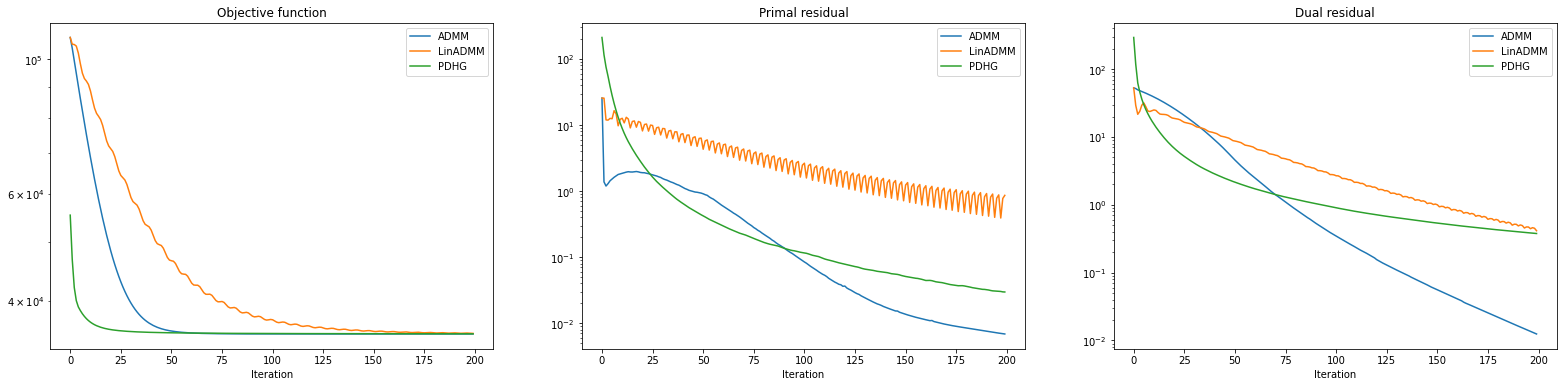

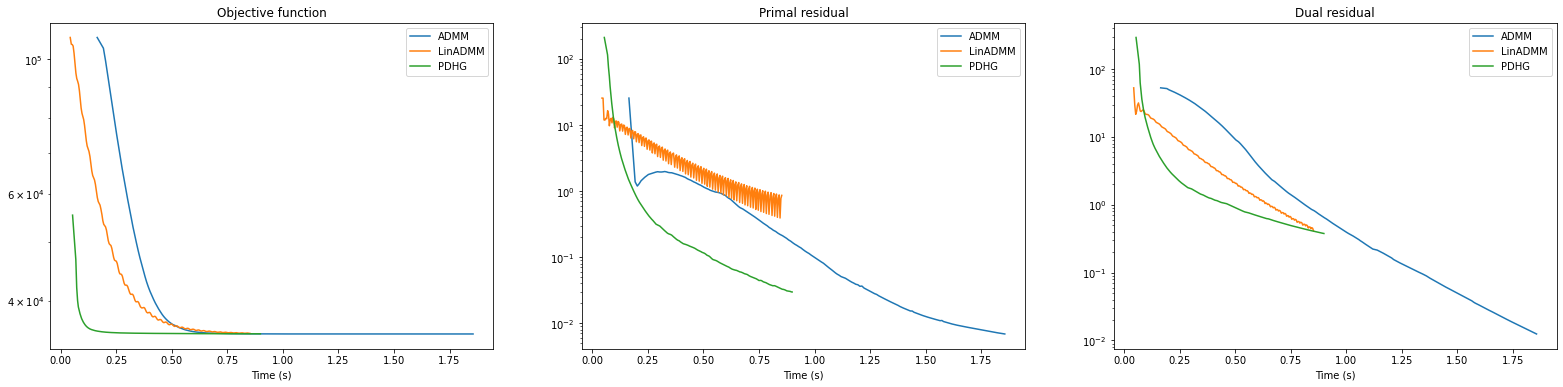

In [9]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_admm.Objective, hist_ladmm.Objective, hist_pdhg.Objective)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Primal_Rsdl, hist_ladmm.Primal_Rsdl, hist_pdhg.Primal_Rsdl)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)
fig.show()

fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_admm.Objective, hist_ladmm.Objective, hist_pdhg.Objective)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Primal_Rsdl, hist_ladmm.Primal_Rsdl, hist_pdhg.Primal_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)
fig.show()